In [2]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

# Edited by: Edouard Delaire, Ilian Azz

# Install PIP dependencies

In [ ]:
%pip install scipy
%pip install mne==1.7.0
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install darkdetect
# HERE 
# !!!!! The matlabengine version should match the version of MATLAB installed on your system !!!!!
# Check : https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html
%pip install matlabengine==24.1.2

# Load MNE model

In [1]:
import mne
from mne.datasets import sample

data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"
ave_fname = meg_path / "sample_audvis-ave.fif"
cov_fname = meg_path / "sample_audvis-shrunk-cov.fif"
subjects_dir = data_path / "subjects"
condition = "Left Auditory"

# Read noise covariance matrix
noise_cov = mne.read_cov(cov_fname)
# Handling average file
evoked = mne.read_evokeds(ave_fname, condition=condition, baseline=(None, 0))
evoked.crop(tmin=0.04, tmax=0.18)

evoked = evoked.pick(picks="meg", exclude="bads")
# Handling forward solution
forward = mne.read_forward_solution(fwd_fname)

# Convertir à un modèle à orientation libre
# force_fixed: Orientation fixe ou libre
# surf_ori: orientaton vers la surface
forward = mne.convert_forward_solution(forward, force_fixed=True, surf_ori=True)

    365 x 365 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 59) active
Reading C:\Users\Ilian\mne_data\MNE-sample-data\MEG\sample\sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Reading forward solution from C:\Users\Ilian\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
  

# Start & Configure matlab engine
## Start engine and add path

In [2]:
# Start MATLAB engine
import matlab.engine
eng = matlab.engine.start_matlab("-desktop")

# HERE
# Add file to MATLAB path
eng.eval("addpath(genpath('C:/Users/Ilian/Documents/MATLAB/best-brainstorm'))", nargout=0)

## Create matlab structures
### Create HeadModel structure

In [3]:
def GetHeadModel(G, VertexConnectivityMatrix):
    """Generate the MEM "HeadModel" struct

    Parameters
    ----------
    M : np_array, shape (n_channels, n_times)
        The whitened data.
    G : np_array, shape (n_channels, n_dipoles)
        The gain matrix a.k.a. the forward operator. The number of locations
        is n_dipoles / n_orient. n_orient will be 1 for a fixed orientation
        constraint or 3 when using a free orientation model.
    VertexConnectivityMatrix : sparse_matrix, shape (n_dipoles, n_dipoles)
        The adjacency matrix of the source space.
        
    Returns
    -------
    HeadModel : dict
    """
    HeadModel = {}
    HeadModel["Gain"] = {
        "matrix":  matlab.double(G.tolist()),
        "modality": "MEG",
    }
    HeadModel["vertex_connectivity"] =  matlab.double(VertexConnectivityMatrix.toarray().tolist())

    return HeadModel

### Create MEMOptions structure

In [4]:
def GetMEMOptions(M, DataTimes, NoiseCov):
    """Generate the MEM "HeadModel" struct

    Parameters
    ----------
    M : np_array, shape (n_channels, n_times)
        The whitened data.
    G : np_array, shape (n_channels, n_dipoles)
        The gain matrix a.k.a. the forward operator. The number of locations
        is n_dipoles / n_orient. n_orient will be 1 for a fixed orientation
        constraint or 3 when using a free orientation model.
    DataTimes : np_array, shape (n_times,)
        The time points of the data.
    NoiseCov : np_array, shape (n_channels, n_channels)
        The noise covariance matrix.
        
    Returns
    -------
    MEMOptions : dict
    """
    number_of_sensors = M.shape[0]
    
    MEMOptions = eng.be_cmem_pipelineoptions()

    MEMOptions["mandatory"] = {} 
    MEMOptions["mandatory"]["DataTime"] = matlab.double(DataTimes.tolist())
    MEMOptions["mandatory"]["Data"] = matlab.double(M.tolist())
    
    MEMOptions["mandatory"]["ChannelTypes"] =  ["MEG"] * number_of_sensors
    MEMOptions["mandatory"]["DataTypes"] =  ["MEG"]
    MEMOptions["mandatory"]["pipeline"] =  "cMEM"



    MEMOptions["optional"]["DataFile"] = ""
    MEMOptions["optional"]["HeadModelFile"] = ""
    # Baseline can be empty if NoiseCov is defined
    MEMOptions["optional"]["Baseline"] = []
    MEMOptions["optional"]["BaselineTime"] = []
    MEMOptions["optional"]["TimeSegment"] = matlab.double([DataTimes[0], DataTimes[-1]])
    MEMOptions["optional"]["Channel"] = []
    MEMOptions["optional"]["ChannelFlag"] = []


    MEMOptions["solver"]["NoiseCov"] = matlab.double(NoiseCov.tolist())
    MEMOptions["solver"]["NoiseCov_recompute"] = 0


    # Default parameters
    MEMOptions["optional"]["active_mean_method"] = 2
    MEMOptions["optional"]["alpha_method"] = 3
    MEMOptions["optional"]["alpha_threshold"] = 0
    MEMOptions["optional"]["initial_lambda"] = 1
    MEMOptions["optional"]["depth_weigth_MNE"] = 0
    MEMOptions["optional"]["depth_weigth_MEM"] = 0

    return MEMOptions

# Define solver methods

In [5]:
import numpy as np

def apply_solver(solver, evoked, forward, noise_cov, loose=0.0, depth=0.8):
    """Call a custom solver on evoked data.

    This function does all the necessary computation:

    - to select the channels in the forward given the available ones in
      the data
    - to take into account the noise covariance and do the spatial whitening
    - to apply loose orientation constraint as MNE solvers
    - to apply a weigthing of the columns of the forward operator as in the
      weighted Minimum Norm formulation in order to limit the problem
      of depth bias.

    Parameters
    ----------
    solver : callable
        The solver takes 3 parameters: data M, gain matrix G, number of
        dipoles orientations per location (1 or 3). A solver shall return
        2 variables: X which contains the time series of the active dipoles
        and an active set which is a boolean mask to specify what dipoles are
        present in X.
    evoked : instance of mne.Evoked
        The evoked data
    forward : instance of Forward
        The forward solution.
    noise_cov : instance of Covariance
        The noise covariance.
    loose : float in [0, 1] | 'auto'
        Value that weights the source variances of the dipole components
        that are parallel (tangential) to the cortical surface. If loose
        is 0 then the solution is computed with fixed orientation.
        If loose is 1, it corresponds to free orientations.
        The default value ('auto') is set to 0.2 for surface-oriented source
        space and set to 1.0 for volumic or discrete source space.
    depth : None | float in [0, 1]
        Depth weighting coefficients. If None, no depth weighting is performed.

    Returns
    -------
    stc : instance of SourceEstimate
        The source estimates.
    """
    # Import the necessary private functions
    from mne.inverse_sparse.mxne_inverse import (
        _make_sparse_stc,
        _prepare_gain,
        _reapply_source_weighting,
        is_fixed_orient,
    )

    all_ch_names = evoked.ch_names

    # Handle depth weighting and whitening (here is no weights)
    forward, gain, gain_info, whitener, source_weighting, mask = _prepare_gain(
        forward,
        evoked.info,
        noise_cov,
        pca=False,
        depth=depth,
        loose=loose,
        weights=None,
        weights_min=None,
        rank=None,
    )

    # Select channels of interest 
    channel_names = forward['sol']['row_names']
    indices_meg = [i for i, name in enumerate(channel_names) if name.startswith('MEG')]
    # indices_meg.pop()
    gain = gain[indices_meg, :]

    # Select channels of interest
    sel = [all_ch_names.index(name) for name in gain_info["ch_names"]]
    M = evoked.data[sel]

    # n_orient = 1 if is_fixed_orient(forward) else 3
    ####### SOLVER

    vertex_connectivity_matrix = mne.spatial_src_adjacency(forward['src'])

    X, active_set = solver(M, gain, vertex_connectivity_matrix, evoked.times, noise_cov.data)
    # X = _reapply_source_weighting(X, source_weighting, active_set)

    stc = _make_sparse_stc(
        X, active_set, forward, tmin=evoked.times[0], tstep=1.0 / evoked.info["sfreq"]
    )

    return stc

In [6]:
def solver(M, G, vertex_connectivity_matrix, data_times, noise_cov):
    """Run L2 penalized regression and keep 10 strongest locations.

    Parameters
    ----------
    M : array, shape (n_channels, n_times)
        The whitened data.
    G : array, shape (n_channels, n_dipoles)
        The gain matrix a.k.a. the forward operator. The number of locations
        is n_dipoles / n_orient. n_orient will be 1 for a fixed orientation
        constraint or 3 when using a free orientation model.
    data_times : array, shape (n_times,)
        The time points of the data.
    noise_cov : array, shape (n_channels, n_channels)
        The noise covariance matrix.

    Returns
    -------
    X : array, (n_active_dipoles, n_times)
        The time series of the dipoles in the active set.
    active_set : array (n_dipoles)
        Array of bool. Entry j is True if dipole j is in the active set.
        We have ``X_full[active_set] == X`` where X_full is the full X matrix
        such that ``M = G X_full``.
    """
    # # Transfer M and G to MATLAB workspace
    eng.workspace['HeadModel'] = GetHeadModel(G, vertex_connectivity_matrix)
    eng.workspace['MEMOptions'] = GetMEMOptions(M, data_times, noise_cov)

    # Prepare and call the MATLAB function using the variables in the workspace
    (Results, OPTIONS) = eng.eval("be_main_call(HeadModel, MEMOptions)", nargout=2)

    ImageGridAmp_np = np.array(Results["ImageGridAmp"])

    # TODO : Extract the active set, do not create a np.ones array
    return ImageGridAmp_np, np.ones(G.shape[1], dtype=bool)

# Call solver

In [7]:
loose, depth = 0.0, 0.8  # corresponds to loose orientation
# loose, depth = 0.0, 0.8  # corresponds to free orientation
stc = apply_solver(solver, evoked, forward, noise_cov, loose, depth)

info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 366 channels remain after picking
Selected 305 channels
Creating the depth weighting matrix...
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 305 dim * 5.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
-- number of adjacent vertices : 8196


C:\Users\Ilian\AppData\Local\Temp\ipykernel_26876\1064125929.py:81: RuntimeWarning: 8.5% of original source space vertices have been omitted, tri-based adjacency will have holes.
Consider using distance-based adjacency or morphing data to all source space vertices.
  vertex_connectivity_matrix = mne.spatial_src_adjacency(forward['src'])


ok


# Show results

## Brain 3D activity

In [8]:
initial_time = -0.1
brain = stc.plot(
    subjects_dir=subjects_dir,
    initial_time=initial_time,
    # clim=dict(kind="value", lims=[0, 5e-11, 1e-10]),
    smoothing_steps=7,
    hemi='both',
)

Using pyvistaqt 3d backend.

Using control points [1.33017628e-15 1.99711448e-15 2.32556428e-14]


Using control points [8.68381660e-16 1.26105620e-15 3.78216454e-15]


## Amplitude for each source and vetex

Total number of active sources: 7498


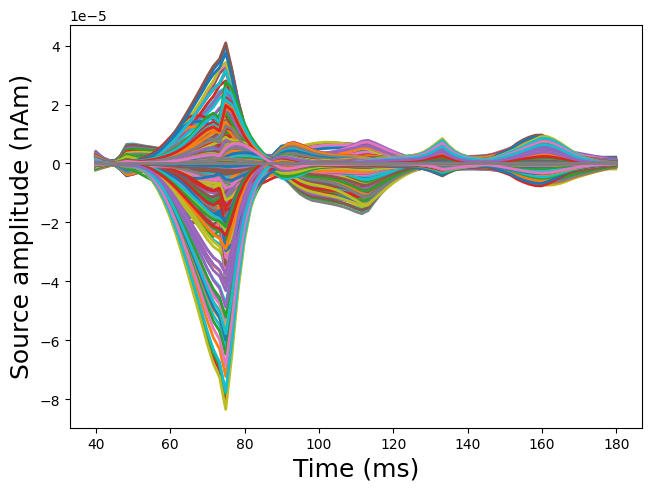

In [17]:
from mne.viz import plot_sparse_source_estimates
res = plot_sparse_source_estimates(forward["src"], stc, bgcolor=(1, 1, 1), opacity=0.1)

## Compare with MNE Default method

In [20]:
from mne import read_source_estimate
from mne.minimum_norm import apply_inverse, make_inverse_operator

fname_stc = meg_path / "sample_audvis-meg"

inverse_operator = make_inverse_operator(
    evoked.info, forward, noise_cov, loose=0, depth=0
)

stc = apply_inverse(
    evoked,
    inverse_operator,
    pick_ori=None,
    method="MNE"
)

# Define plotting parameters
surfer_kwargs = dict(
    hemi="both",
    subjects_dir=subjects_dir,
    smoothing_steps=7,
)

# Plot surface
brain = stc.plot(**surfer_kwargs)

info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 366 channels remain after picking
Selected 305 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 305 dim * 5.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.65505
    scaling factor to adjust the trace = 7.99196e+19 (nchan = 305 nzero = 3)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace di

Using control points [1.24055489e-10 1.44821494e-10 3.36381465e-10]
Using control points [1.24055489e-10 1.44821494e-10 3.36381465e-10]
